Alternatywnym podejściem jest użycie fingerprintu [MACCS](https://oi.readthedocs.io/en/latest/bioinfo/mol_fp/maccs.html) - wtedy zupełnie nie przyglądamy się interakcjom ligand-białko, interesuje nas tylko ligand. Ponieważ nie jest to temat projektu, sprawdziliśmy tylko kilka dobrze rokujących modeli. Wyniki są zaskakująco dobre.

In [24]:
import sys
sys.path.append('..')
from sbap.sdf import ChemblSdfReader

import pathlib

import pandas as pd
import numpy as np
from tdc import Evaluator
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [21]:
SDF_FILE = "../molecules/human_serum_albumin_CHEMBL_data.sdf"

In [22]:
reader = ChemblSdfReader()
molecules = reader.parse(pathlib.Path(SDF_FILE))
print(f'read {len(molecules)} molecules')
print(molecules[0]['mol'])
print(molecules[0]['standardValue'])

read 530 molecules

Mrv2114 03112311192D          

 25 27  0  0  0  0            999 V2000
   -3.5724   -2.8875    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.8579   -2.4750    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1434   -2.8875    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1434   -3.7125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.8579   -4.1250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4289   -2.4750    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145   -2.8875    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000   -2.4750    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -2.8875    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -2.4750    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -1.6500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  

In [23]:
X = []
y = []

for record in molecules:
    mol = Chem.MolFromMolBlock(record['mol'])
    X.append(MACCSkeys.GenMACCSKeys(mol).ToBitString())
    # DON'T FORGET TO CHANGE!
    # cytochrome: y.append(np.log10(record['standardValue'])
    # albumin: y.append(np.log10(100.1 - record['standardValue']))  
    y.append(np.log10(100.1 - record['standardValue']))  
X = np.array([np.fromstring(s,'u1') - ord('0') for s in X])
y = np.array(y, dtype='f')

In [15]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

def test_model(model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(x_train, y_train)
    
    fig, ax = plt.subplots()
    ax.axline((0, 0), slope=1)

    predictions = model.predict(x_train)  
    rmse_score = rmse(y_train, predictions)
    mae_score = mae(y_train, predictions)
    r2_score = r_squared(y_train, predictions)
    print(f'on train set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_train, predictions)

    predictions = model.predict(x_test) 
    rmse_score = rmse(y_test, predictions)
    mae_score = mae(y_test, predictions)
    r2_score = r_squared(y_test, predictions)
    print(f'on test set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_test, predictions)
    plt.show()

In [19]:
print(X.shape)

(530, 167)


## Example models

on train set: RMSE, MAE, R2 = 0.26850491629310647, 0.18679550729923422, 0.8267609070312703
on test set: RMSE, MAE, R2 = 0.5601690826057841, 0.4089058736857021, 0.42938512390229877


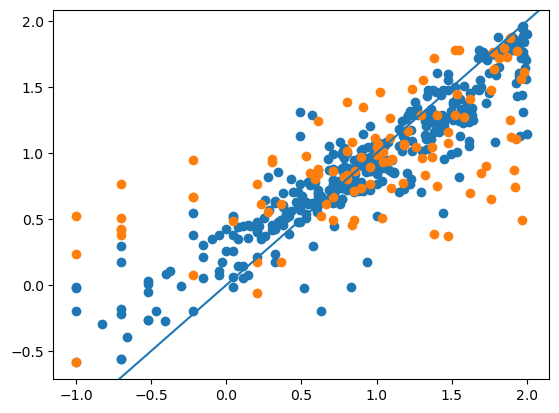

In [18]:
model = RandomForestRegressor(n_estimators=300, max_depth=10)
test_model(model)

on train set: RMSE, MAE, R2 = 0.16337214442079173, 0.04428051395732711, 0.9494493393328047
on test set: RMSE, MAE, R2 = 0.628622440378699, 0.40945231126435766, 0.2809193931019893


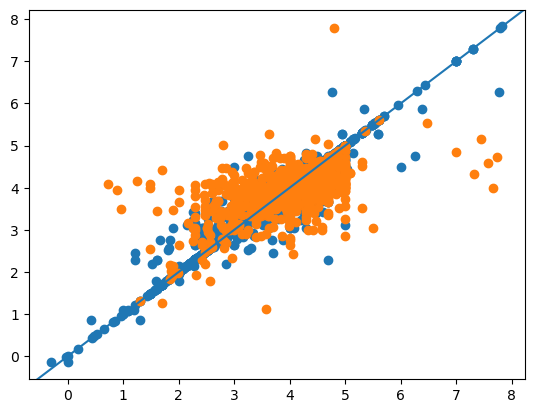

In [59]:
model = KNeighborsRegressor(n_neighbors=7, weights='distance', metric='l1')
test_model(model)

on train set: RMSE, MAE, R2 = 0.23169937638261898, 0.14167880984066833, 0.8817904841038513
on test set: RMSE, MAE, R2 = 0.5509160741360991, 0.3853379862032597, 0.24100361484317157


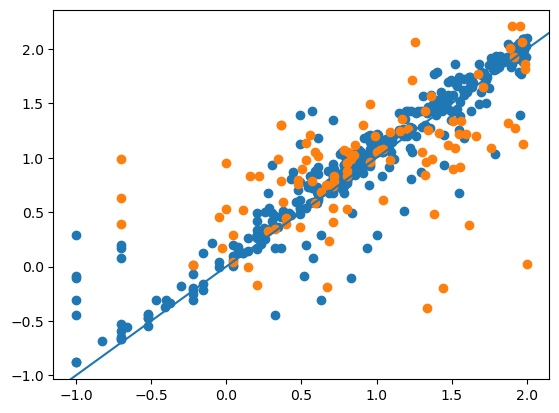

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
nn = MLPRegressor(hidden_layer_sizes=(100, 50, 10), alpha=0.002)
test_model(nn)